## Códigos utilizados em Python

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from IPython.display import display

# Configuração estética
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Carregando datasets
penguins = sns.load_dataset('penguins').dropna()
iris = sns.load_dataset('iris')

# Verifica se os datasets foram carregados corretamente
print("Penguins Dataset Head:")
display(penguins.head())
print("\nIris Dataset Head:")
display(iris.head())

Penguins Dataset Head:


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male



Iris Dataset Head:


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Média Empírica: 190.10, Desvio Padrão Empírico: 6.52
Média estimada: 190.10, Desvio Padrão: 6.50


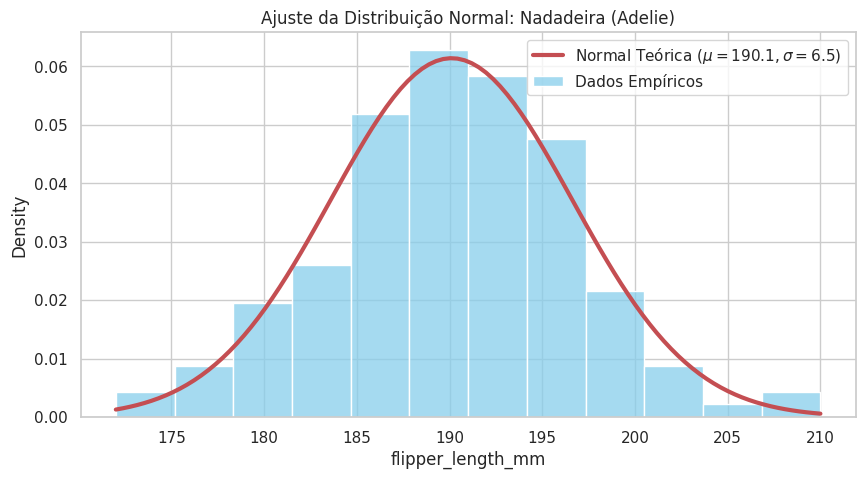

In [13]:
# 1. Selecionar dados (apenas da espécie Adelie para evitar bimodalidade)
dados_adelie = penguins[penguins['species'] == 'Adelie']['flipper_length_mm']

# Média e desvio padrão empíricos
media_empirica = dados_adelie.mean()
desvio_empirico = dados_adelie.std()
print(f"Média Empírica: {media_empirica:.2f}, Desvio Padrão Empírico: {desvio_empirico:.2f}")

# 2. Estimar parâmetros (Máxima Verossimilhança)
mu, sigma = stats.norm.fit(dados_adelie)
print(f"Média estimada: {mu:.2f}, Desvio Padrão: {sigma:.2f}")

# 3. Gerar pontos para a curva teórica
x = np.linspace(dados_adelie.min(), dados_adelie.max(), 100)
pdf_teorica = stats.norm.pdf(x, loc=mu, scale=sigma)

# 4. Plotagem
plt.figure(figsize=(10, 5))

# Histograma (density=True é CRUCIAL para comparar com a PDF)
sns.histplot(dados_adelie, stat="density", kde=False, label="Dados Empíricos", color="skyblue")

# Curva Teórica
plt.plot(
    x,
    pdf_teorica,
    'r-',
    lw=3,
    label=rf'Normal Teórica ($\mu={mu:.1f}, \sigma={sigma:.1f}$)'
)

plt.title('Ajuste da Distribuição Normal: Nadadeira (Adelie)')
plt.legend()
plt.show()

In [14]:
prob = stats.norm.cdf(185, loc=mu, scale=sigma)
print(f"Probabilidade teórica (P < 185mm): {prob:.2%}")

# Verificação nos dados reais
prob_real = (dados_adelie < 185).mean()
print(f"Frequência nos dados reais: {prob_real:.2%}")

Probabilidade teórica (P < 185mm): 21.62%
Frequência nos dados reais: 18.49%


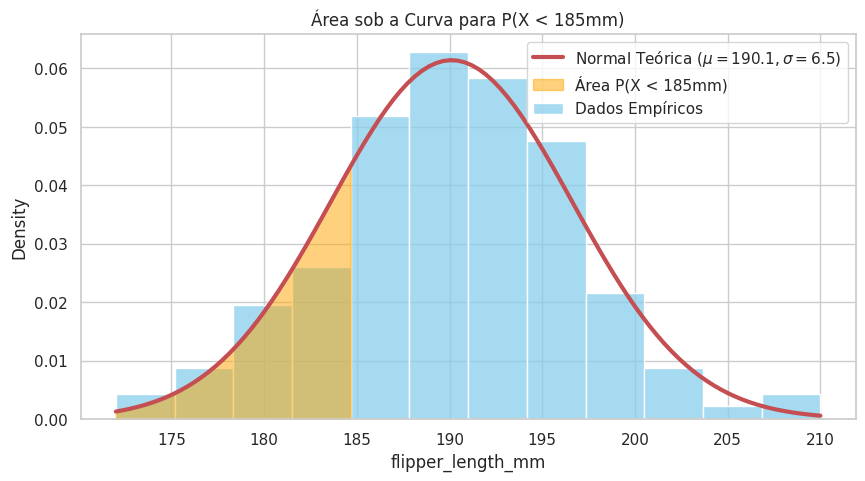

In [15]:
# Gráfico indicando a área sob a curva
plt.figure(figsize=(10, 5))
sns.histplot(dados_adelie, stat="density", kde=False, label="Dados Empíricos", color="skyblue")
plt.plot(x, pdf_teorica, 'r-', lw=3, label=rf'Normal Teórica ($\mu={mu:.1f}, \sigma={sigma:.1f}$)')
plt.fill_between(x, 0, pdf_teorica, where=(x < 185), color='orange', alpha=0.5, label='Área P(X < 185mm)')
plt.title('Área sob a Curva para P(X < 185mm)')
plt.legend()
plt.show()

Probabilidade de ser Gentoo (p): 0.357


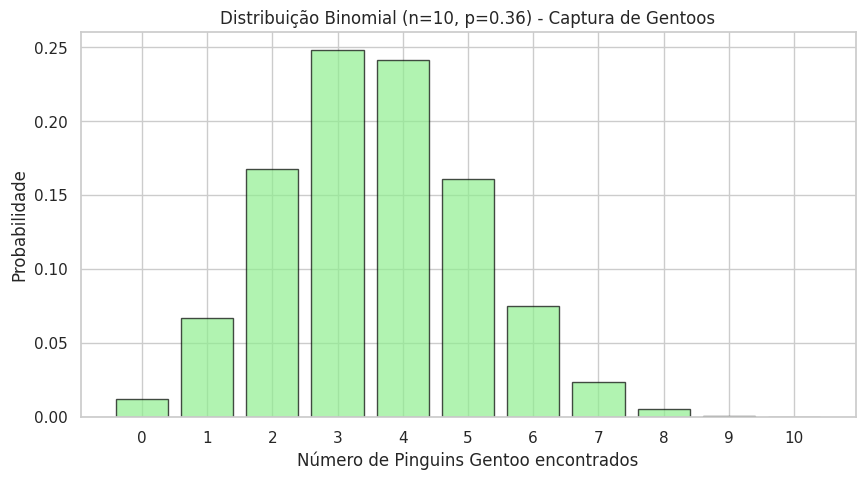

In [16]:
# 1. Definir parâmetros
n_tentativas = 10  # Tamanho da amostra que vamos coletar

# Probabilidade 'p' real baseada no dataset ("População da Ilha")
p_gentoo = (penguins['species'] == 'Gentoo').mean()

print(f"Probabilidade de ser Gentoo (p): {p_gentoo:.3f}")

# 2. Gerar a distribuição teórica para k sucessos (0 a 10)
k_values = np.arange(0, n_tentativas + 1)
prob_binom = stats.binom.pmf(k_values, n=n_tentativas, p=p_gentoo)

# 3. Visualização
plt.figure(figsize=(10, 5))
plt.bar(k_values, prob_binom, color='lightgreen', edgecolor='black', alpha=0.7)
plt.title(f'Distribuição Binomial (n={n_tentativas}, p={p_gentoo:.2f}) - Captura de Gentoos')
plt.xlabel('Número de Pinguins Gentoo encontrados')
plt.ylabel('Probabilidade')
plt.xticks(k_values)
plt.show()

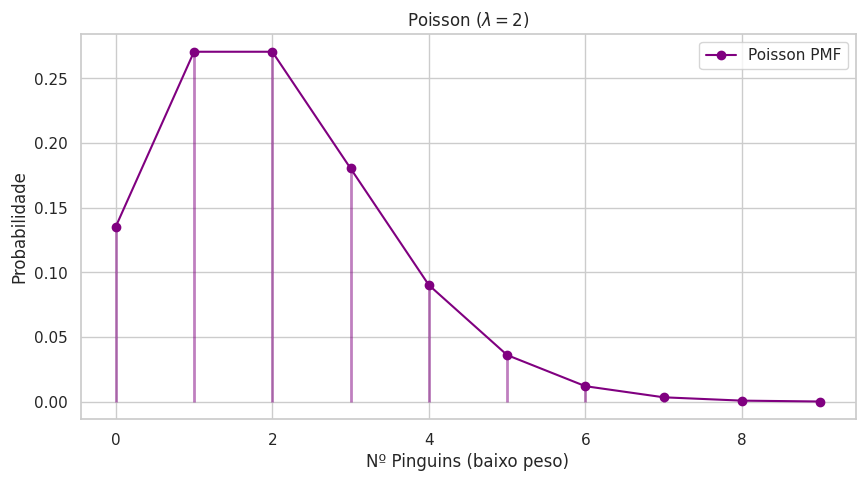

In [18]:
# 1. Parâmetro Lambda
lambda_pinguins = 2  # Média esperada

# 2. Calcular probabilidades
k_ocorr = np.arange(0, 10)
prob_poisson = stats.poisson.pmf(k_ocorr, mu=lambda_pinguins)

# 3. Visualização
plt.figure(figsize=(10, 5))
plt.plot(k_ocorr, prob_poisson, 'o-', color='purple', label='Poisson PMF')
plt.vlines(k_ocorr, 0, prob_poisson, colors='purple', lw=2, alpha=0.5)

plt.title(f'Poisson ($\\lambda={lambda_pinguins}$)')
plt.xlabel('Nº Pinguins (baixo peso)')
plt.ylabel('Probabilidade')
plt.legend()
plt.show()

## Inferência

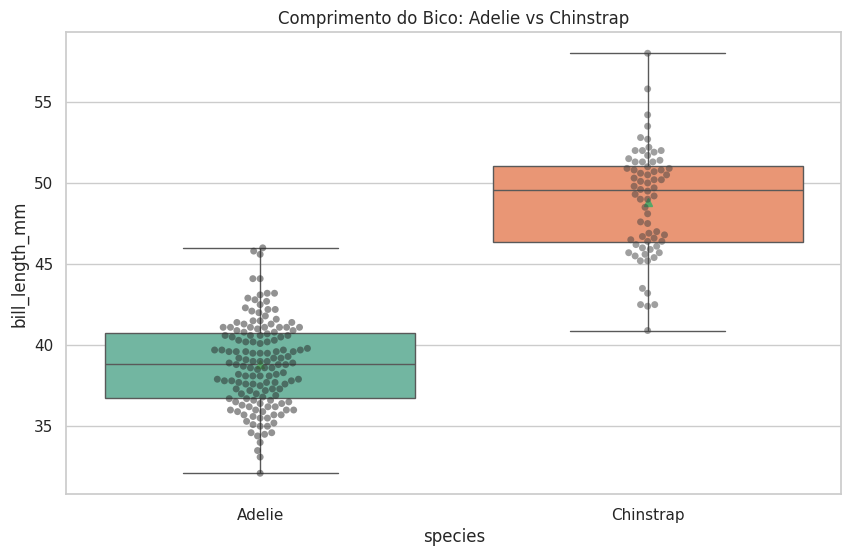

In [33]:
# Filtrando os dados
adelie = penguins[penguins['species'] == 'Adelie']['bill_length_mm']
chinstrap = penguins[penguins['species'] == 'Chinstrap']['bill_length_mm']

plt.figure(figsize=(10, 6))

# Boxplot para comparar centro e dispersão
sns.boxplot(
    x='species', y='bill_length_mm', hue='species', 
    data=penguins[penguins['species'].isin(['Adelie', 'Chinstrap'])],
    palette="Set2", showmeans=True
)

# Swarmplot para ver pontos individuais
sns.swarmplot(
    x='species', y='bill_length_mm', hue='species',
    data=penguins[penguins['species'].isin(['Adelie', 'Chinstrap'])],
    palette='dark:.25', alpha=0.5
)

plt.title('Comprimento do Bico: Adelie vs Chinstrap')
plt.show()

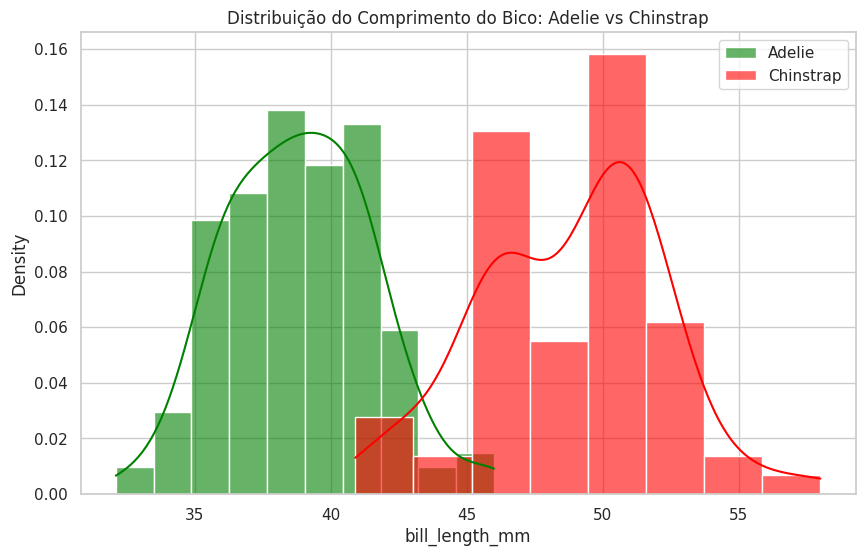

In [29]:
# Histogramas sobrepostos
plt.figure(figsize=(10, 6))
sns.histplot(adelie, color='green', label='Adelie', stat='density', kde=True, alpha=0.6)
sns.histplot(chinstrap, color='red', label='Chinstrap', stat='density', kde=True, alpha=0.6)
plt.title('Distribuição do Comprimento do Bico: Adelie vs Chinstrap')
plt.legend()
plt.show()

In [24]:
# Testando normalidade para cada grupo
stat_ad, p_ad = stats.shapiro(adelie)
stat_ch, p_ch = stats.shapiro(chinstrap)

print(f"Shapiro-Wilk Adelie: p={p_ad:.4f}")
print(f"Shapiro-Wilk Chinstrap: p={p_ch:.4f}")

if p_ad > 0.05 and p_ch > 0.05:
    print("Assumimos normalidade em ambos os grupos.")
else:
    print("Alerta: Desvio da normalidade detectado.")

Shapiro-Wilk Adelie: p=0.6848
Shapiro-Wilk Chinstrap: p=0.1941
Assumimos normalidade em ambos os grupos.


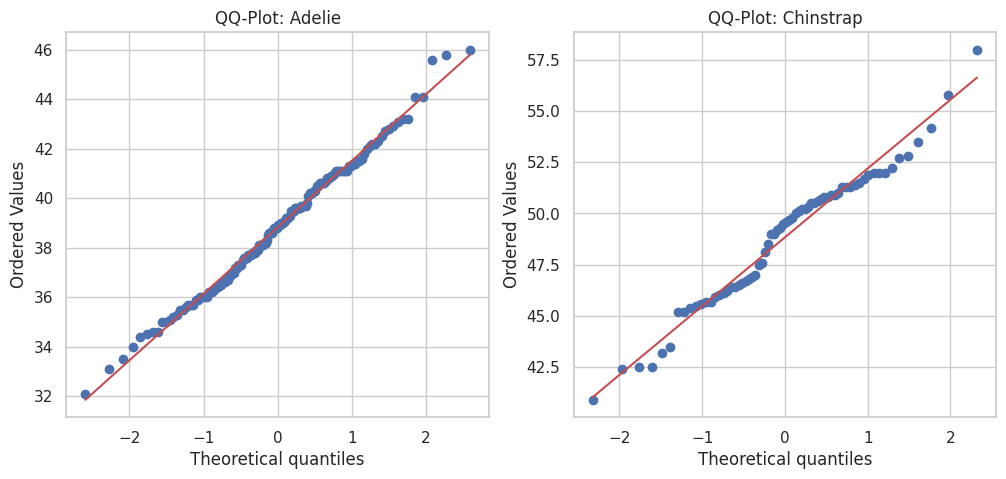

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

stats.probplot(adelie, dist="norm", plot=ax[0])
ax[0].set_title('QQ-Plot: Adelie')

stats.probplot(chinstrap, dist="norm", plot=ax[1])
ax[1].set_title('QQ-Plot: Chinstrap')

plt.show()

In [31]:
# Teste de Levene para igualdade de variâncias
stat_lev, p_lev = stats.levene(adelie, chinstrap)
print(f"Teste de Levene (Homocedasticidade): p={p_lev:.4f}")

equal_var = p_lev > 0.05  # Se p > 0.05, variâncias iguais
print(f"Igualdade de variâncias assumida: {equal_var}")

# Teste T
t_stat, p_val = stats.ttest_ind(adelie, chinstrap, equal_var=equal_var)

print(f"\nResultados do Teste T:")
print(f"Estatística t: {t_stat:.4f}")
print(f"P-valor: {p_val:.2e}")

Teste de Levene (Homocedasticidade): p=0.0345
Igualdade de variâncias assumida: False

Resultados do Teste T:
Estatística t: -21.7125
P-valor: 3.15e-41


In [34]:
alpha = 0.05
print(f"Média Adelie: {adelie.mean():.2f} mm | Média Chinstrap: {chinstrap.mean():.2f} mm")
print(f"Diferença: {chinstrap.mean() - adelie.mean():.2f} mm")
if p_val < alpha:
    print("Conclusão: REJEITAMOS H0.")
    print("Há evidência estatística de diferença significativa entre as médias.")
else:
    print("Conclusão: FALHAMOS em rejeitar H0.")
    print("Não há evidência suficiente para afirmar diferença entre as médias.")

Média Adelie: 38.82 mm | Média Chinstrap: 48.83 mm
Diferença: 10.01 mm
Conclusão: REJEITAMOS H0.
Há evidência estatística de diferença significativa entre as médias.


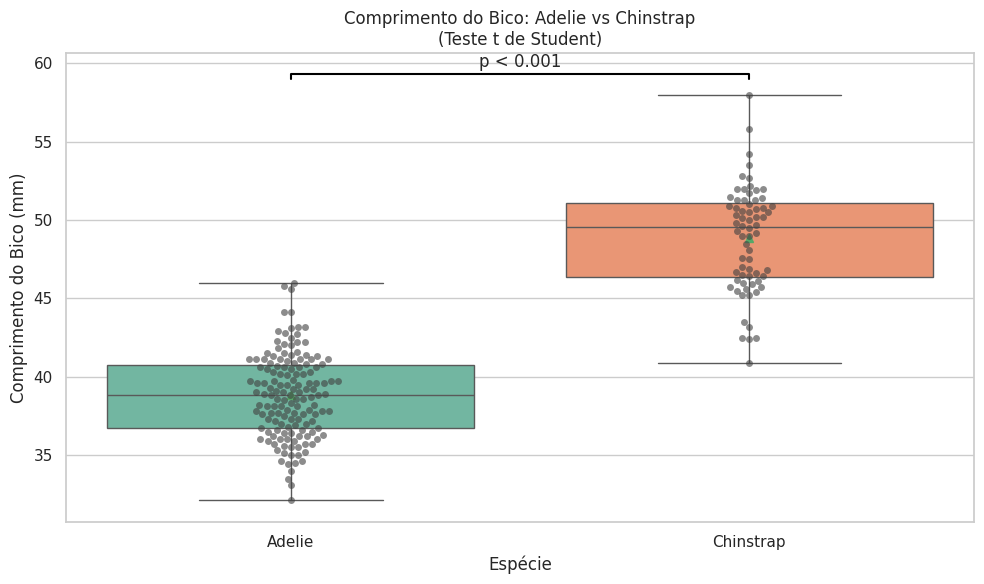

In [37]:
dados = penguins[penguins['species'].isin(['Adelie', 'Chinstrap'])]
plt.figure(figsize=(10, 6))

# Boxplot
sns.boxplot(
    x='species',
    y='bill_length_mm',
    hue='species',
    data=dados,
    palette='Set2',
    showmeans=True,
    legend=False
)

# Pontos individuais
sns.swarmplot(
    x='species',
    y='bill_length_mm',
    data=dados,
    color='0.25',
    alpha=0.6
)

# Altura da anotação (um pouco acima do maior valor)
y_max = dados['bill_length_mm'].max()
y_min = dados['bill_length_mm'].min()
altura = y_max + 0.05 * (y_max - y_min)

# Posições no eixo x (Adelie = 0, Chinstrap = 1)
x1, x2 = 0, 1

# Linha horizontal
plt.plot([x1, x1, x2, x2],
         [altura - 0.3, altura, altura, altura - 0.3],
         lw=1.5, color='black')

# Texto do p-valor
if p_val < 0.001:
    texto_p = "p < 0.001"
elif p_val < 0.01:
    texto_p = "p < 0.01"
elif p_val < 0.05:
    texto_p = "p < 0.05"
else:
    texto_p = f"p = {p_val:.2f}"

plt.text(
    (x1 + x2) / 2,
    altura + 0.2,
    texto_p,
    ha='center',
    va='bottom',
    fontsize=12
)

plt.title('Comprimento do Bico: Adelie vs Chinstrap\n(Teste t de Student)')
plt.xlabel('Espécie')
plt.ylabel('Comprimento do Bico (mm)')
plt.tight_layout()
plt.show()

## ANOVA

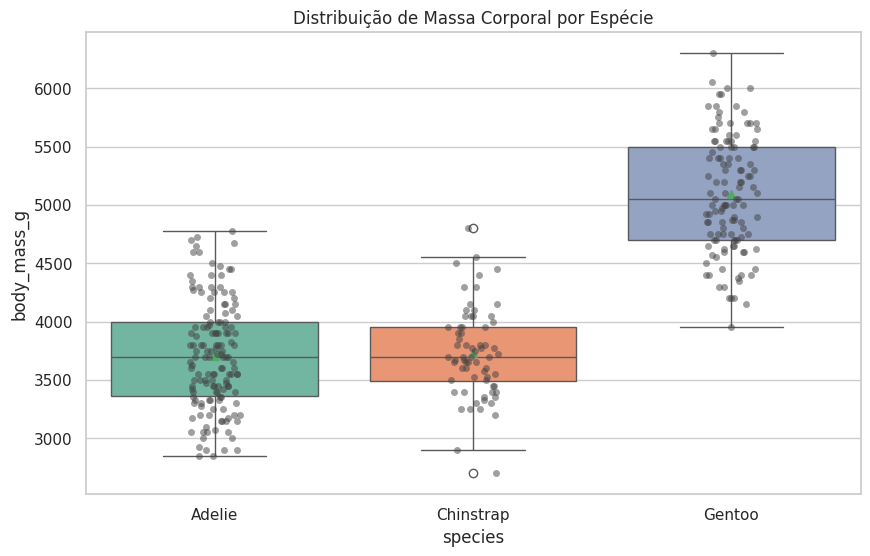

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='species', y='body_mass_g', hue='species',
    data=penguins, palette="Set2", showmeans=True
)
sns.stripplot(
    x='species', y='body_mass_g', 
    data=penguins, color=".25", 
    alpha=0.5, jitter=True
)
plt.title('Distribuição de Massa Corporal por Espécie')
plt.show()

In [41]:
# Ajuste do modelo (Ordinary Least Squares)
modelo_anova = ols('body_mass_g ~ species', data=penguins).fit()

# Tabela ANOVA
tabela_anova = sm.stats.anova_lm(modelo_anova, typ=2)
print(tabela_anova)

                sum_sq     df           F        PR(>F)
species   1.451902e+08    2.0  341.894895  3.744505e-81
Residual  7.006945e+07  330.0         NaN           NaN


Shapiro-Wilk nos Resíduos: p=0.0783
Teste de Levene: p=0.0064


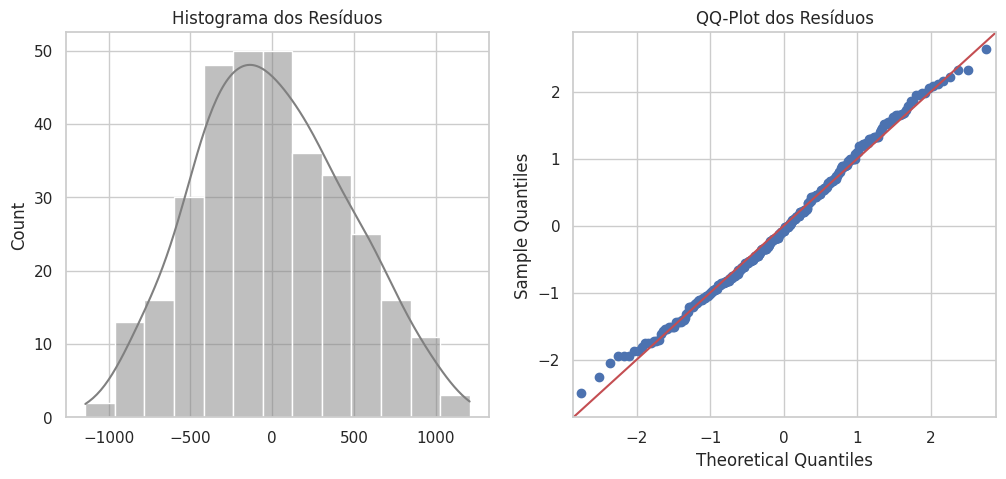

In [42]:
residuos = modelo_anova.resid

# 1. Normalidade dos Resíduos (Shapiro-Wilk)
stat_sw, p_sw = stats.shapiro(residuos)
print(f"Shapiro-Wilk nos Resíduos: p={p_sw:.4f}")

# 2. Homocedasticidade (Levene)
stat_lev, p_lev = stats.levene(
    penguins[penguins['species'] == 'Adelie']['body_mass_g'],
    penguins[penguins['species'] == 'Chinstrap']['body_mass_g'],
    penguins[penguins['species'] == 'Gentoo']['body_mass_g']
)
print(f"Teste de Levene: p={p_lev:.4f}")

# Visualização
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(residuos, kde=True, ax=ax[0], color='gray')
ax[0].set_title("Histograma dos Resíduos")
sm.qqplot(residuos, line='45', fit=True, ax=ax[1])
ax[1].set_title("QQ-Plot dos Resíduos")
plt.show()

In [43]:
tukey = pairwise_tukeyhsd(endog=penguins['body_mass_g'],
                          groups=penguins['species'],
                          alpha=0.05)

print(tukey)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1    group2   meandiff p-adj    lower     upper   reject
---------------------------------------------------------------
   Adelie Chinstrap   26.9239 0.9164 -132.3528  186.2005  False
   Adelie    Gentoo 1386.2726    0.0 1252.2897 1520.2554   True
Chinstrap    Gentoo 1359.3487    0.0 1194.4304 1524.2671   True
---------------------------------------------------------------


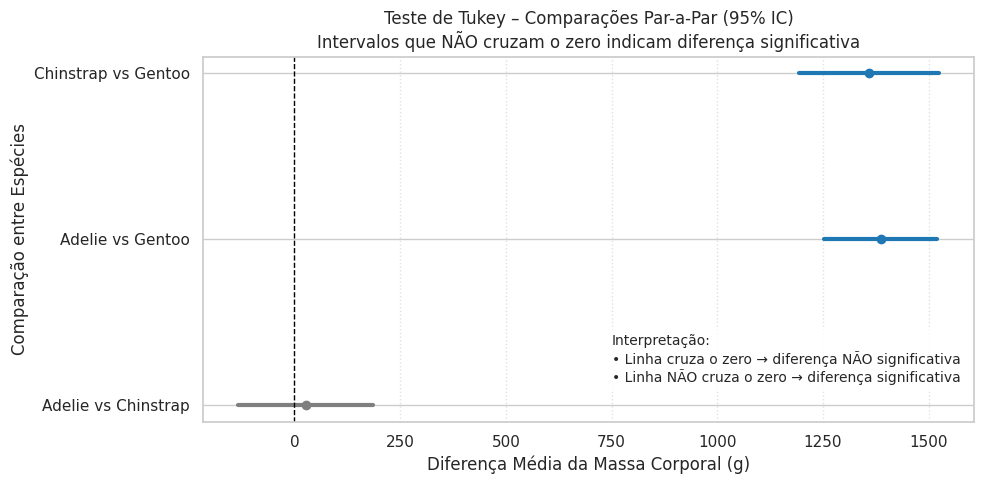

In [ ]:
tukey_df = pd.DataFrame(
    tukey._results_table.data[1:],
    columns=tukey._results_table.data[0]
)

# Criar rótulo da comparação
tukey_df['comparacao'] = tukey_df['group1'] + " vs " + tukey_df['group2']

# Converter colunas numéricas
for col in ['meandiff', 'lower', 'upper']:
    tukey_df[col] = tukey_df[col].astype(float)

# 2. Plotagem dos Intervalos de Confiança
plt.figure(figsize=(10, 5))

y_pos = range(len(tukey_df))

for i, row in tukey_df.iterrows():
    
    # Define cor baseada na significância
    if row['reject']:
        cor = 'tab:blue'      # significativo
    else:
        cor = 'tab:gray'      # não significativo
    
    # Intervalo de confiança
    plt.plot(
        [row['lower'], row['upper']],
        [i, i],
        color=cor,
        linewidth=3
    )
    
    # Ponto da diferença média
    plt.plot(
        row['meandiff'],
        i,
        'o',
        color=cor
    )

# Linha vertical no zero (referência)
plt.axvline(
    x=0,
    color='black',
    linestyle='--',
    linewidth=1
)

# Configurações dos eixos
plt.yticks(y_pos, tukey_df['comparacao'])
plt.xlabel('Diferença Média da Massa Corporal (g)')
plt.ylabel('Comparação entre Espécies')

plt.title(
    'Teste de Tukey – Comparações Par-a-Par (95% IC)\n'
    'Intervalos que NÃO cruzam o zero indicam diferença significativa'
)

# Legenda manual
plt.text(
    0.53, 0.1,
    "Interpretação:\n"
    "• Linha cruza o zero → diferença NÃO significativa\n"
    "• Linha NÃO cruza o zero → diferença significativa",
    transform=plt.gca().transAxes,
    fontsize=10,
    va='bottom',
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.9)
)

plt.grid(axis='x', linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()
 